In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/train.csv')
val = pd.read_csv('data/test.csv')
res = pd.read_csv('data/sample_submit.csv')

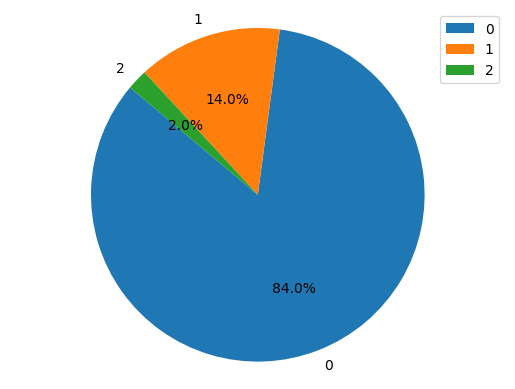

In [3]:
category_counts = df['target'].value_counts()
plt.pie(category_counts, labels={0:'正常',1:'糖尿病前期',2:'糖尿病'}, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.legend()
plt.grid(True)
plt.show()

In [4]:
target = df['target']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop(['id','target'],axis=1))
scaled_val = scaler.transform(val.drop(['id'],axis=1))
df = pd.DataFrame(scaled_data, columns=df.drop(['id','target'],axis=1).columns)
val = pd.DataFrame(scaled_val, columns=val.drop(['id'],axis=1).columns)

df['target'] = target

In [5]:
bmi_mean = df[df['target']==0]['BMI'].mean()
df['BMI_'] = (df['BMI'] - bmi_mean).abs()
val['BMI_'] = (val['BMI'] - bmi_mean).abs()

bmi_mean = df[df['target']==0]['Education'].mean()
df['Education_'] = (df['Education'] - bmi_mean).abs()
val['Education_'] = (val['Education'] - bmi_mean).abs()

bmi_mean = df[df['target']==0]['Income'].mean()
df['Income_'] = (df['Income'] - bmi_mean).abs()
val['Income_'] = (val['Income'] - bmi_mean).abs()

In [6]:
col_list = []
for i in df.columns:
    if df[i].min() == 0 and df[i].max() == 1:
        df[i] = df[i].apply(lambda x:0 if x < 0.5 else 1)
        val[i] = val[i].apply(lambda x:0 if x < 0.5 else 1)
    else:    
        col_list.append(i)
col_list.remove('target')

In [7]:
feature_interactions = [
    ('Age', 'Sex'),                    # 年龄和性别
    ('HighBP', 'HighChol'),            # 高血压和高酒精
    ('PhysActivity', 'BMI'),           # 身体活动和体重指数
    ('MentHlth', 'PhysHlth'),         # 心理健康和身体健康
    # ('Fruits', 'Veggies'),            # 水果和蔬菜
    ('Education', 'Income'),           # 教育和收入
    ('Smoker', 'HvyAlcoholConsump'),   # 吸烟者和酗酒者
    ('CholCheck', 'HeartDiseaseorAttack'),  # 胆固醇检查和心脏疾病
    # ('HighBP', 'Stroke'),                # 高血压和中风
    # ('HighChol', 'CholCheck'),           # 高酒精和胆固醇检查
    # ('PhysActivity', 'DiffWalk'),        # 身体活动和走路/爬楼困难
    ('Fruits', 'Veggies', 'BMI'),       # 水果、蔬菜和体重指数的组合
    ('Education', 'Income', 'GenHlth'),  # 教育、收入和健康状况的组合
    # ('Smoker', 'Age', 'MentHlth'),      # 吸烟者、年龄和心理健康的组合
    # ('HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost'),  # 酗酒者、医疗保健和医疗成本的组合
]

for j,feaList in enumerate(feature_interactions):
    poly = PolynomialFeatures(degree=len(feaList))
    df_poly = poly.fit_transform(df[list(feaList)])
    val_poly = poly.transform(val[list(feaList)])
    
    df_poly_df = pd.DataFrame(df_poly, columns=[f'poly{j}_{i}' for i in range(df_poly.shape[1])])
    val_poly_df = pd.DataFrame(val_poly, columns=[f'poly{j}_{i}' for i in range(val_poly.shape[1])])
    
    df = pd.concat([df, df_poly_df], axis=1)
    val = pd.concat([val, val_poly_df], axis=1)
    
# feature_interaction_list = [item for sublist in feature_interactions for item in sublist]
# feature_interaction_list  =list(set(feature_interaction_list))
# df.drop(feature_interaction_list,axis=1,inplace=True)
# val.drop(feature_interaction_list,axis=1,inplace=True)

In [8]:
X = df.drop(['target'],axis=1)
y = target
valX = val

# poly = PolynomialFeatures(degree=2)
# X = poly.fit_transform(X)
# valX = poly.fit_transform(valX)

# # 使用方差筛选
# variance_threshold = VarianceThreshold(threshold=1)
# X = variance_threshold.fit_transform(X)
# valX = variance_threshold.fit_transform(valX)

# 划分测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
lgb_params = {
    'n_estimators':500,
    'objective': 'multiclass',
    'num_class': 3,
    'max_depth': 10,
    'min_child_samples': 3,
    'random_state': 42,
    'subsample': 0.8, 
    'learning_rate':0.03,
    'num_leaves': 64,
    'boosting_type': 'gbdt',
    "lambda_l1": 0.5,
    "lambda_l2": 0.5,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'device': 'gpu',
}
 
# 创建 LightGBM 数据集
sample_weights = np.ones_like(y_train)  
sample_weights[y_train == 1] = 3  
sample_weights[y_train == 2] = 2  

train_data = lgb.Dataset(X_train, label=y_train, 
                         # weight=sample_weights
                        )
val_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 训练模型
model = lgb.train(params=lgb_params,
                  train_set=train_data,
                  valid_sets=[val_data],
                  early_stopping_rounds=50,  
                  verbose_eval=100)  # 每隔多少轮输出日志信息

lgb_train = model.predict(X_train)
lgb_test = model.predict(X_test)
lgb_val = model.predict(valX)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24019
[LightGBM] [Info] Number of data points in the train set: 240000, number of used features: 97
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 76 dense feature groups (17.40 MB) transferred to GPU in 0.016700 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.173912
[LightGBM] [Info] Start training from score -3.921022
[LightGBM] [Info] Start training from score -1.967483
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.393866
[200]	valid_0's multi_logloss: 0.389099
[300]	valid_0's multi_logloss: 0.386844
[400]	valid_0's multi_logloss: 0.385066
[500]	valid_0's multi_logloss: 0.383658
Did not meet early stopping. Best iteration is:

In [10]:
# 定义XGBoost参数
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'max_depth': 10,
    'min_child_weight': 3,
    'seed': 42,
    'subsample': 0.8,
    'eta': 0.03,
    'gamma': 0.6,
    'colsample_bytree': 0.8,
    'n_jobs': -1,
    'tree_method': 'gpu_hist',  
}

# 创建XGBoost数据矩阵
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(valX)

# 训练模型
num_round = 500
early_stopping_rounds = 50

evals = [(dtest, 'eval')]
model = xgb.train(params=xgb_params,
                  dtrain=dtrain,
                  num_boost_round=num_round,
                  evals=evals,
                  early_stopping_rounds=early_stopping_rounds,
                  verbose_eval=100)

# 预测
xgb_train = model.predict(dtrain)
xgb_test = model.predict(dtest)
xgb_val = model.predict(dval)

[0]	eval-mlogloss:1.06901
[100]	eval-mlogloss:0.40677
[200]	eval-mlogloss:0.38439
[300]	eval-mlogloss:0.37852
[400]	eval-mlogloss:0.37428
[499]	eval-mlogloss:0.37117


In [11]:
# 定义CatBoost参数
catboost_params = {
    'iterations': 500,
    'learning_rate': 0.03,
    'depth': 10,
    'l2_leaf_reg': 3,
    'border_count': 32,
    'thread_count': -1,
    'loss_function': 'MultiClass',
    'random_seed': 42,
    'task_type': 'GPU'
}

# 创建CatBoost模型
model_catboost = CatBoostClassifier(**catboost_params)

# 训练模型
model_catboost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

# 预测
catboost_train = model_catboost.predict_proba(X_train)
catboost_test = model_catboost.predict_proba(X_test)
catboost_val = model_catboost.predict_proba(valX)

0:	learn: 1.0601978	test: 1.0604434	best: 1.0604434 (0)	total: 36.1ms	remaining: 18s
100:	learn: 0.3977133	test: 0.4080338	best: 0.4080338 (100)	total: 3.35s	remaining: 13.2s
200:	learn: 0.3751191	test: 0.3933533	best: 0.3933533 (200)	total: 6.43s	remaining: 9.57s
300:	learn: 0.3643838	test: 0.3898557	best: 0.3898557 (300)	total: 9.44s	remaining: 6.24s
400:	learn: 0.3555352	test: 0.3874384	best: 0.3874384 (400)	total: 12.4s	remaining: 3.06s
499:	learn: 0.3473107	test: 0.3854386	best: 0.3854386 (499)	total: 15.4s	remaining: 0us
bestTest = 0.3854386068
bestIteration = 499


In [12]:
def find_best_thresholds(y_pred,y_true=y_test.copy()):
    y_pred_prob = y_pred.copy()
    best_thresholds = [0.1, 0.1, 0.1]  # 初始阈值
    best_f1 = 0 

    for threshold_0 in tqdm(range(0, 101, 3), desc="Threshold 0"):
        for threshold_1 in range(0, 101, 3):
            for threshold_2 in range(0, 101, 3):
                thresholds = [threshold_0 / 100.0, threshold_1 / 100.0, threshold_2 / 100.0]

                y_pred = y_pred_prob.copy()
                y_pred[:, 2] = (y_pred[:, 2] >= thresholds[2]).astype(int)
                y_pred[:, 1] = (y_pred[:, 1] >= thresholds[1]).astype(int)
                y_pred[:, 0] = (y_pred[:, 0] >= thresholds[0]).astype(int)

                f1 = f1_score(y_true, np.argmax(y_pred, axis=1), average='macro')

                if f1 > best_f1:
                    best_f1 = f1
                    best_thresholds = thresholds
    print('best_f1 is:', best_f1)
    print('best_thresholds is:', best_thresholds)
    return best_f1, best_thresholds

thresholds = []
f1s = []
for i in [xgb_test,lgb_test,catboost_test]:
    best_f1, best_thresholds = find_best_thresholds(i)
    thresholds.append(best_thresholds)
    f1s.append(best_f1)

Threshold 0: 100%|█████████████████████████████████████████████████████████████████████| 34/34 [09:23<00:00, 16.58s/it]


best_f1 is: 0.5617971944641528
best_thresholds is: [0.84, 0.09, 0.27]


Threshold 0: 100%|█████████████████████████████████████████████████████████████████████| 34/34 [09:40<00:00, 17.07s/it]


best_f1 is: 0.5309758794237179
best_thresholds is: [0.84, 0.09, 0.27]


Threshold 0: 100%|█████████████████████████████████████████████████████████████████████| 34/34 [09:25<00:00, 16.63s/it]

best_f1 is: 0.5165545845410534
best_thresholds is: [0.93, 0.06, 0.27]


In [13]:
thresholds

[[0.84, 0.09, 0.27], [0.84, 0.09, 0.27], [0.93, 0.06, 0.27]]

In [14]:
f1s

[0.5617971944641528, 0.5309758794237179, 0.5165545845410534]

In [15]:
xgb_test[:, 2] = (xgb_test[:, 2] >= thresholds[0][2]).astype(int)
xgb_test[:, 1] = (xgb_test[:, 1] >= thresholds[0][1]).astype(int)
xgb_test[:, 0] = (xgb_test[:, 0] >= thresholds[0][0]).astype(int)
xgb_train[:, 2] = (xgb_train[:, 2] >= thresholds[0][2]).astype(int)
xgb_train[:, 1] = (xgb_train[:, 1] >= thresholds[0][1]).astype(int)
xgb_train[:, 0] = (xgb_train[:, 0] >= thresholds[0][0]).astype(int)
xgb_val[:, 2] = (xgb_val[:, 2] >= thresholds[0][2]).astype(int)
xgb_val[:, 1] = (xgb_val[:, 1] >= thresholds[0][1]).astype(int)
xgb_val[:, 0] = (xgb_val[:, 0] >= thresholds[0][0]).astype(int)

lgb_test[:, 2] = (lgb_test[:, 2] >= thresholds[1][2]).astype(int)
lgb_test[:, 1] = (lgb_test[:, 1] >= thresholds[1][1]).astype(int)
lgb_test[:, 0] = (lgb_test[:, 0] >= thresholds[1][0]).astype(int)
lgb_train[:, 2] = (lgb_train[:, 2] >= thresholds[1][2]).astype(int)
lgb_train[:, 1] = (lgb_train[:, 1] >= thresholds[1][1]).astype(int)
lgb_train[:, 0] = (lgb_train[:, 0] >= thresholds[1][0]).astype(int)
lgb_val[:, 2] = (lgb_val[:, 2] >= thresholds[1][2]).astype(int)
lgb_val[:, 1] = (lgb_val[:, 1] >= thresholds[1][1]).astype(int)
lgb_val[:, 0] = (lgb_val[:, 0] >= thresholds[1][0]).astype(int)

catboost_test[:, 2] = (catboost_test[:, 2] >= thresholds[2][2]).astype(int)
catboost_test[:, 1] = (catboost_test[:, 1] >= thresholds[2][1]).astype(int)
catboost_test[:, 0] = (catboost_test[:, 0] >= thresholds[2][0]).astype(int)
catboost_train[:, 2] = (catboost_train[:, 2] >= thresholds[2][2]).astype(int)
catboost_train[:, 1] = (catboost_train[:, 1] >= thresholds[2][1]).astype(int)
catboost_train[:, 0] = (catboost_train[:, 0] >= thresholds[2][0]).astype(int)
catboost_val[:, 2] = (catboost_val[:, 2] >= thresholds[2][2]).astype(int)
catboost_val[:, 1] = (catboost_val[:, 1] >= thresholds[2][1]).astype(int)
catboost_val[:, 0] = (catboost_val[:, 0] >= thresholds[2][0]).astype(int)

In [16]:
trainX = np.hstack((
    np.argmax(xgb_train, axis=1).reshape(-1, 1)*f1s[0]/sum(f1s),
    np.argmax(lgb_train, axis=1).reshape(-1, 1)*f1s[1]/sum(f1s),
    np.argmax(catboost_train, axis=1).reshape(-1, 1)*f1s[2]/sum(f1s),
    # np.argmax(gbdt_train, axis=1).reshape(-1, 1),
    # np.argmax(rf_train, axis=1).reshape(-1, 1)
    (xgb_train + lgb_train + catboost_train) / 3
))

testX = np.hstack((
    np.argmax(xgb_test, axis=1).reshape(-1, 1)*f1s[0]/sum(f1s),
    np.argmax(lgb_test, axis=1).reshape(-1, 1)*f1s[1]/sum(f1s),
    np.argmax(catboost_test, axis=1).reshape(-1, 1)*f1s[2]/sum(f1s),
    # np.argmax(gbdt_test, axis=1).reshape(-1, 1),
    # np.argmax(rf_test, axis=1).reshape(-1, 1)
    (xgb_test + lgb_test + catboost_test) / 3
))

valX = np.hstack((
    np.argmax(xgb_val, axis=1).reshape(-1, 1)*f1s[0]/sum(f1s),
    np.argmax(lgb_val, axis=1).reshape(-1, 1)*f1s[1]/sum(f1s),
    np.argmax(catboost_val, axis=1).reshape(-1, 1)*f1s[2]/sum(f1s),
    # np.argmax(gbdt_val, axis=1).reshape(-1, 1),
    # np.argmax(rf_val, axis=1).reshape(-1, 1)
    (xgb_val + lgb_val + catboost_val) / 3
))


train_proba = (xgb_train + lgb_train + catboost_train) / 3
test_proba = (xgb_test + lgb_test + catboost_test) / 3
val_proba = (xgb_val + lgb_val + catboost_val) / 3

In [17]:
model = GradientBoostingClassifier(
    n_estimators=100,  
    # learning_rate=0.01,  
    max_depth=3,  
    min_samples_split=2, 
    min_samples_leaf=1,  
    random_state=42
)

# 使用交叉验证来评估模型性能，助于防止过拟合
scores = cross_val_score(model, trainX, y_train, cv=5)  # 使用5折交叉验证
mean_score = scores.mean()

# 训练模型
model.fit(trainX, y_train)

# 打印模型性能分数
print("Mean Cross-Validation Score:", mean_score)


train_proba = model.predict_proba(trainX)
test_proba = model.predict_proba(testX)
y_pure = model.predict_proba(valX)

Mean Cross-Validation Score: 0.8995625


In [18]:
# 调用函数
y_pred_prob = test_proba.copy()
best_f1, best_thresholds = find_best_thresholds(y_pred_prob)

Threshold 0: 100%|█████████████████████████████████████████████████████████████████████| 34/34 [09:50<00:00, 17.38s/it]

best_f1 is: 0.562363354291317
best_thresholds is: [0.42, 0.03, 0.0]


In [19]:
best_f1

0.562363354291317

In [20]:
best_thresholds

[0.42, 0.03, 0.0]

In [21]:
train_proba[:, 2] = (train_proba[:, 2] >= best_thresholds[2]).astype(int)
train_proba[:, 1] = (train_proba[:, 1] >= best_thresholds[1]).astype(int)
train_proba[:, 0] = (train_proba[:, 0] >= best_thresholds[0]).astype(int)
test_proba[:, 2] = (test_proba[:, 2] >= best_thresholds[2]).astype(int)
test_proba[:, 1] = (test_proba[:, 1] >= best_thresholds[1]).astype(int)
test_proba[:, 0] = (test_proba[:, 0] >= best_thresholds[0]).astype(int)

print(f1_score(y_train, np.argmax(train_proba, axis=1),average='macro'))
print(f1_score(y_test, np.argmax(test_proba, axis=1),average='macro'))

0.8013125701677138
0.562363354291317


In [22]:
# y_pure = model.predict_proba(val)

y_pure[:, 2] = (y_pure[:, 2] >= best_thresholds[2]).astype(int)
y_pure[:, 1] = (y_pure[:, 1] >= best_thresholds[1]).astype(int)
y_pure[:, 0] = (y_pure[:, 0] >= best_thresholds[0]).astype(int)
res.target = np.argmax(y_pure, axis=1)
res.to_csv('resv6.csv')